This python notebook will train 12 'denoisers' (corresponding to different choices of hyperparameters) according to our paper "Fast, Accurate Manifold Denoising using Riemannian Tunneling Optimization" on a training set of 100,000 noisy gravitational waves. 

Then, we  will evaluate the performance of the learned denoiser on a test set of 20,000 noisy gravitational waves. We will compare the test-time efficiency of our method as compared to Nearest Neighbour in a Complexity vs Performance Trade-Off curve. 


Then, we perform an "ablation study" by considering the complexity performance tradeoff when we use only First Order Steps, and again when we use only Zero Order Steps.

In [ ]:
## Import relevant libraries
import numpy as np
import math
from sklearn.decomposition import PCA

# plotting 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
all_colors = list(mcolors.CSS4_COLORS)


# manifold traversal
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..","..")))

from utils.utils_demo_growth import main_fn_no_vis, MT_perform_traversal
from utils.utils_manifold import create_manifold
from utils.utils_data_loader import save_data, load_data
from utils.utils_plotly import GW_plotter
from utils.utils_train import train_network


# helping
import pickle
import time
import subprocess

In [2]:
manifold_type = 'gw'
path_prefix = '/data/shiyu/projects/MT/MT_code/GW'
data_path = f'{path_prefix}/GW_data'
save_dir = f"{path_prefix}/Ablation_Study"
train_waves_filename = 'datawaves_100000_spinsFalse_nonuniform.npy'
test_waves_filename = 'datawaves_20000_spinsFalse_nonuniform.npy'

# Generate Gravitational Wave Train Set

In [3]:
## load waves
input_file = os.path.join(data_path, train_waves_filename)
train_waves = np.load(input_file)


X_natural_train = train_waves.T
N_train = X_natural_train.shape[1]
D = X_natural_train.shape[0]
d = 2


sigma = 0.01    # noise standard deviation
X_train = X_natural_train + sigma * np.random.randn(D, N_train)

# Training Denoisers

In [4]:
def train_network_wrapper(R_is_const, R_denoising, R_1st_order_nbrs, d_parallel, prod_coeff, exp_coeff, name):
    # initialize an MTN object 
    M = 0 # number of landmarks

    "local approximation info"
    Q = [] # list of landmarks w
    T = [] # list of basis matrices
    S_collection = [] # a list of sigma matrices obtained after each TISVD

    P = [] # number of points in each approximation 

    "first order graph info"
    N1 = [] # list of lists of first order neighbors
    W1 = [] # list of lists of weights of first order neighbors 
    Xi = [] # list of lists of edge embeddings 

    "zero order graph info" 
    N0 = [] # list of lists of zero order neighbors
    W0 = [] # list of lists of weights of zero order neighbors 
    tangent_colors = []

    local_params = [Q, T, S_collection, P, Xi]
    nbrs_info = [N1, W1, N0, W0]
    misc = [tangent_colors, D, d, M, P]
    network_params = [local_params, nbrs_info, misc]
    N_cur = 0

    all_MT_SE      = []
    mean_MT_SE     = [] 
    mean_data_SE   = []

    errors = [mean_MT_SE, mean_data_SE, all_MT_SE]
    other_params = (sigma, R_1st_order_nbrs)
    Rd_params = (R_is_const, R_denoising, d_parallel, prod_coeff, exp_coeff)
    
    # train online method in batches:
    # NOTE: the batches' only purpose is to notify the user regarding the progress of learning.
    # there is no algorithmic implication to training in batches
    # the data is still fed individually in an online fashion, except that the time for processing "batch_size" consecutive samples is tracked and printed
    batch_size = 4000 #set batch_size as desired
    num_batches = N_train // batch_size
    time_array = []
    errors_array = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size
        cur_time, errors, network_params = train_network(start_index, end_index, errors, network_params, X = X_train, X_natural = X_natural_train,
                                                            other_params=other_params, Rd_params=Rd_params)
        time_array.append(cur_time)
        errors_array.append(errors)
        print(f"{end_index} samples processed...")
    
    print(f"DONE... TOTAL TIME = {np.sum(np.array(time_array))}")
    return network_params, errors

In [5]:
# define hyperparams
R_is_const_list = [False,
                   True,
                   False,
                   True,
                   False,
                   False,
                   True,
                   False,
                   True,
                   True,
                   True,
                   True]

R_denoising_list = [np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.75 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.39 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2 * sigma**2 * D),
                    np.sqrt(2.19 * sigma**2 * D),
                    np.sqrt(3.13 * sigma**2 * D),
                    np.sqrt(1.94 * sigma**2 * D)]

R_1st_order_nbrs_list = [np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.75 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.75 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(3.53 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D)]

d_parallel_list = [np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(8 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(4 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(30 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d)]

prod_coeff_list = [1.2,
                   1.2,
                   1.2,
                   1.2,
                   1.3,
                   1.15,
                   1.2,
                   1.5,
                   1.2,
                   1.2,
                   1.2,
                   1.2]

exp_coeff_list = [1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/3,
                  1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/2]

name_list = ["NETWORK_1",
             "NETWORK_2",
             "NETWORK_3",
             "NETWORK_4",
             "NETWORK_5",
             "NETWORK_6",
             "NETWORK_7",
             "NETWORK_8",
             "NETWORK_9",
             "NETWORK_10",
             "NETWORK_11",
             "NETWORK_12"]

network_params_list = []
errors_list = []

In [6]:
for i in range(len(name_list)):
    print(f"TRAINING {name_list[i]}")
    network_params, errors = train_network_wrapper(R_is_const_list[i], R_denoising_list[i], R_1st_order_nbrs_list[i], d_parallel_list[i], prod_coeff_list[i], exp_coeff_list[i], name_list[i])
    network_params_list.append(network_params)
    errors_list.append(errors)
    print("~~~~~~~~~~~~\n \n \n ")

with open(os.path.join(save_dir, f'network_params_list.pkl'), 'wb') as f:
    pickle.dump(network_params_list, f)

TRAINING NETWORK_1
TOTAL TIME =  3.1645522117614746
4000 samples processed...
TOTAL TIME =  5.139671564102173
8000 samples processed...
TOTAL TIME =  7.504694223403931
12000 samples processed...
TOTAL TIME =  7.496026992797852
16000 samples processed...
TOTAL TIME =  10.000284910202026
20000 samples processed...
TOTAL TIME =  12.557705640792847
24000 samples processed...
TOTAL TIME =  13.464469194412231
28000 samples processed...
TOTAL TIME =  15.05010199546814
32000 samples processed...
TOTAL TIME =  15.47284984588623
36000 samples processed...
TOTAL TIME =  18.114498376846313
40000 samples processed...
TOTAL TIME =  17.303395748138428
44000 samples processed...
TOTAL TIME =  18.08336639404297
48000 samples processed...
TOTAL TIME =  16.681947708129883
52000 samples processed...
TOTAL TIME =  21.9868381023407
56000 samples processed...
TOTAL TIME =  21.840946674346924
60000 samples processed...
TOTAL TIME =  22.509955883026123
64000 samples processed...
TOTAL TIME =  23.59901189804077

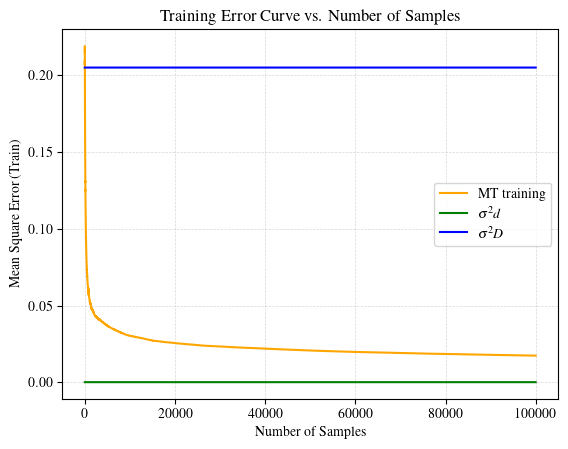

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})


#first network
[mean_MT_SE, mean_data_SE, all_MT_SE] = errors_list[0]
sigma_sq_d = [sigma**2 * d for i in range(len(mean_MT_SE))]
sigma_sq_D = [sigma**2 * D for i in range(len(mean_MT_SE))]



plt.plot(mean_MT_SE, color='orange',label='MT training')
plt.plot(sigma_sq_d, color='green', label=r'$\sigma^2 d$')
plt.plot(sigma_sq_D, color='blue', label=r'$\sigma^2 D$')
plt.legend()
plt.xlabel('Number of Samples')
plt.ylabel('Mean Square Error (Train)')
plt.title('Training Error Curve vs. Number of Samples')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.savefig('training_error_curve.pdf', format='pdf', bbox_inches='tight')


# Analyze Networks

Make the Test Data

In [8]:
## load waves
test_input_file = os.path.join(data_path, test_waves_filename)
test_waves = np.load(test_input_file)


X_natural_test = test_waves.T
N_test = X_natural_test.shape[1]
X_test = X_natural_test + sigma * np.random.randn(D, N_test)

In [46]:
print(f'X_test shape is {X_test.shape}')

X_test shape is (2048, 20000)


Analyze each network

In [9]:
# Helper Methods
def exhaustive_search(x,Q, calc_mults = True):
        exh_mults = 0
        distances = np.sum((Q - x).T**2, axis=0) # have to play around with dimensions using .T
        best_idx = np.argmin(distances)
        best_dist = distances[best_idx]
        if calc_mults == True:
            exh_mults = D*len(Q)
        return best_idx, best_dist, exh_mults



def FO_traversal(x, Q, T, N1, W1, Xi, calc_mults = True):
    mults = 0
    if calc_mults == True:
        D = len(x)
        d = len(T[0][0])

    i = 0  # starting vertex

    converged = False
    iter = 0

    trajectory = [i]
    edge_orders = []



    # calculate and print objective for the starting point
    phi = np.sum( (Q[i] - x) ** 2 )

    if calc_mults:
        mults += D 

    while not converged: 

        # compute Riemannian gradient in coordinates
        # this is the gradient of .5 || q - x ||_2^2 with respect to q
        grad_phi = T[i].transpose() @ ( Q[i] - x )

        if calc_mults:
            mults += D*d

        # 1st order outdegree of vertex i
        # ie how many 1st degree neighbors does vertex i have
        deg_1_i = len( N1[i] )

        # find the most correlated edge embedding -- this is the speculated next vertex
        next_i = 0
        best_corr = math.inf

        # check the correlation for each 1st order edge of vertex i with the gradient
        for j in range( 0, deg_1_i ): 
            corr = np.dot( Xi[i][j], grad_phi )

            if (corr < best_corr):
                best_corr = corr
                next_i = N1[i][j]
        
        
        if calc_mults:
            mults += d * deg_1_i

        # compute objective value at speculated next vertex
        next_phi = np.sum( (Q[next_i] - x) ** 2 ) 

        if calc_mults:
            mults += D
        order = 1

        if (next_phi >= phi):
            # If no improvement is found (i.e., next_i == i)
            # declare convergence and exit the loop.
            # print('   MT converged') 
            converged = True 
        else:
            # Otherwise, update i to the new vertex, append to the trajectory, and continue the loop.
            i = next_i 
            phi = next_phi

            trajectory.append(i) 
            edge_orders.append(order) 

            iter += 1 
            
    return i, phi, trajectory, edge_orders, mults





def ZO_traversal(x, Q, T, N0, W0, Xi, calc_mults = True):
    mults = 0
    if calc_mults == True:
        D = len(x)
        d = len(T[0][0])

    i = 0  # starting vertex

    converged = False
    iter = 0

    trajectory = [i]
    edge_orders = []

    while not converged:               
        best_i = 0 
        best_phi = math.inf 

        deg_0_i = len(N0[i])

        # compute the objective at each of the neighbors, record the best objective 
        if calc_mults:
            mults += D * deg_0_i

        for j in range( 0, deg_0_i):
            
            cur_nbr_phi = np.sum( ( Q[ N0[i][j] ] - x ) ** 2 ) 

            if (cur_nbr_phi < best_phi):
                best_phi = cur_nbr_phi
                best_i = N0[i][j]

        order = 0
        next_i = best_i


        if (next_i == i):
            converged = True 
        else:
            # Otherwise, update i to the new vertex, append to the trajectory, and continue the loop.
            i = next_i 

            trajectory.append(i) 
            edge_orders.append(order) 

            iter += 1 
            
    return i, trajectory, edge_orders, mults



def analyze_network(network_params, num_samples):
    
    # unpack data
    [local_params, nbrs_info, misc] = network_params
    (Q, T, S_collection, P, Xi)                = local_params
    (N1, W1, N0, W0)                           = nbrs_info
    (tangent_colors, D, d, M, P)               = misc

    print("Number of landmarks (M):", M)
    print("Number of first-order edges:", sum(len(inner_list) for inner_list in N1))
    print("Number of zero-order edges:", sum(len(inner_list) for inner_list in N0))
    print(f"Total Num Points Assigned to Network: {np.sum(np.array(P))}")

    Q_np = np.array(Q)
    
    FOonly_N1 = N1.copy()

    ZOonly_N0 = []
    for i in range(len(N1)):
        temp = list(set(N1[i] + N0[i]))
        ZOonly_N0.append(temp)


    exh_total_mults = 0
    mt_total_mults = 0
    FOM_total_mults = 0
    ZOM_total_mults = 0

    exh_distces = []
    mt_distces = []
    FOM_distces = []
    ZOM_distces = []

    for i in range(num_samples):
        x= X_test[:,i]
        x_nat = X_natural_test[:,i]

        q_exh, _, exh_mults = exhaustive_search(x, Q_np, calc_mults=True)
        exh_total_mults += exh_mults
        
        q_mt, _, _, _, mt_mults = MT_perform_traversal(x, Q, T, N1, W1,Xi, N0, W0, calc_mults=True)
        mt_total_mults += mt_mults

        q_FOM, _, _, _, FOM_mults = FO_traversal(x=x, Q=Q, T=T, N1=FOonly_N1, W1=W1, Xi=Xi, calc_mults=True)
        FOM_total_mults += FOM_mults

        q_ZOM, _, _, ZOM_mults = ZO_traversal(x=x, Q=Q, T=T, N0=ZOonly_N0, W0=W0, Xi=Xi, calc_mults=True)
        ZOM_total_mults += ZOM_mults

        SQdist_exh = np.sum((x_nat - Q[q_exh])**2)
        SQdist_mt = np.sum((x_nat - Q[q_mt])**2)
        SQdist_FOM = np.sum((x_nat - Q[q_FOM])**2)
        SQdist_ZOM = np.sum((x_nat - Q[q_ZOM])**2)

        mt_distces.append(SQdist_mt)
        exh_distces.append(SQdist_exh)
        FOM_distces.append(SQdist_FOM)
        ZOM_distces.append(SQdist_ZOM)
        
    avg_exh_dist = np.sum(exh_distces) / num_samples
    avg_mt_dist = np.sum(mt_distces) / num_samples
    avg_FOM_dist = np.sum(FOM_distces) / num_samples
    avg_ZOM_dist = np.sum(ZOM_distces) / num_samples

    avg_exh_mults = exh_total_mults / num_samples
    avg_mt_mults = mt_total_mults / num_samples
    avg_FOM_mults = FOM_total_mults / num_samples
    avg_ZOM_mults = ZOM_total_mults / num_samples

    return (avg_exh_dist, avg_exh_mults), (avg_mt_dist, avg_mt_mults), (avg_FOM_dist, avg_FOM_mults), (avg_ZOM_dist, avg_ZOM_mults)


In [ ]:
network_stats_list = []
for i in range(len(network_params_list)):
    print(f"Analyzing {name_list[i]}...")
    network_stats  = analyze_network(network_params_list[i], num_samples=N_test)
    print("DONE! \n \n")
    network_stats_list.append(network_stats)

with open(os.path.join(save_dir, f'network_stats_list.pkl'), 'wb') as f:
    pickle.dump(network_stats_list, f)


Analyzing NETWORK_1...
Number of landmarks (M): 1600
Number of first-order edges: 156862
Number of zero-order edges: 2315
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_2...
Number of landmarks (M): 216
Number of first-order edges: 818
Number of zero-order edges: 405
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_3...
Number of landmarks (M): 1662
Number of first-order edges: 168054
Number of zero-order edges: 2443
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_4...
Number of landmarks (M): 53
Number of first-order edges: 53
Number of zero-order edges: 121
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_5...
Number of landmarks (M): 429
Number of first-order edges: 13605
Number of zero-order edges: 982
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_6...
Number of landmarks (M): 3815
Number of first-order edges: 1163293
Number of zero-order edges: 4900
Total N

# Plotting

### First plot (not for publication)

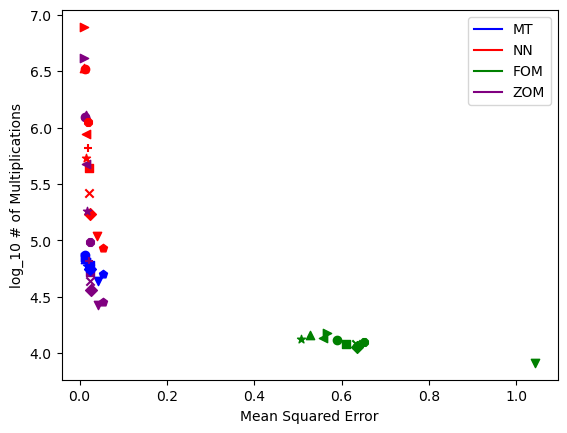

In [ ]:
NN_accuracies = [network_stats_list[i][0][0] for i in range(len(name_list))]
NN_complexities = [network_stats_list[i][0][1] for i in range(len(name_list))]

MT_accuracies = [network_stats_list[i][1][0] for i in range(len(name_list))]
MT_complexities = [network_stats_list[i][1][1] for i in range(len(name_list))]

FOM_accuracies = [network_stats_list[i][2][0] for i in range(len(name_list))]
FOM_complexities = [network_stats_list[i][2][1] for i in range(len(name_list))]

ZOM_accuracies = [network_stats_list[i][3][0] for i in range(len(name_list))]
ZOM_complexities = [network_stats_list[i][3][1] for i in range(len(name_list))]

markers = ['o', 's', '^' , 'v', '<', '>', 'D', '*', '+', 'x', 'p', '8']

from matplotlib.lines import Line2D

for i in range(len(name_list)):
    plt.scatter(NN_accuracies[i], np.log10(NN_complexities[i]), color='red', marker=markers[i])
    plt.scatter(MT_accuracies[i], np.log10(MT_complexities[i]), color='blue', marker=markers[i])
    plt.scatter(FOM_accuracies[i], np.log10(FOM_complexities[i]), color='green', marker=markers[i])
    plt.scatter(ZOM_accuracies[i], np.log10(ZOM_complexities[i]), color='purple', marker=markers[i])
plt.ylabel("log_10 # of Multiplications")
plt.xlabel("Mean Squared Error")
legend_elements = [Line2D([0],[0], color='blue', label='MT'), Line2D([0],[0], color='red', label='NN'),Line2D([0],[0], color='green', label='FOM'),Line2D([0],[0], color='purple', label='ZOM')]
plt.legend(handles=legend_elements)
plt.show()


## For publication

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})

### MT vs NN

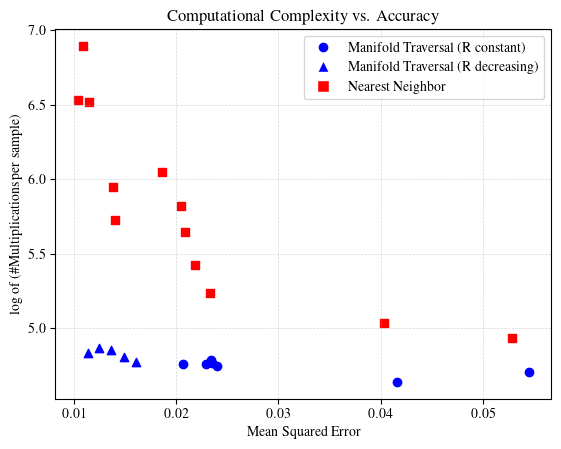

In [27]:
for i in range(len(name_list)): 
    marker_MT = 'o' if R_is_const_list[i] else '^'
    plt.scatter(MT_accuracies[i], np.log10(MT_complexities[i]),  marker=marker_MT, color='blue')
    plt.scatter(NN_accuracies[i], np.log10(NN_complexities[i]), marker='s', color='red')
plt.title('Computational Complexity vs. Accuracy')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")
# plt.legend(['Manifold Traversal','Nearest Neighbor'])
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Manifold Traversal (R constant)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Manifold Traversal (R decreasing)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='Nearest Neighbor', markerfacecolor='red', markersize=8),
]
plt.legend(handles=legend_elements)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.savefig('MT_NN_tradeoff.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Ablation Study

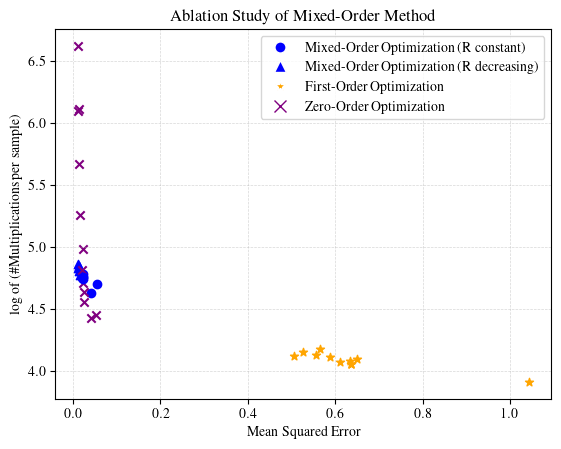

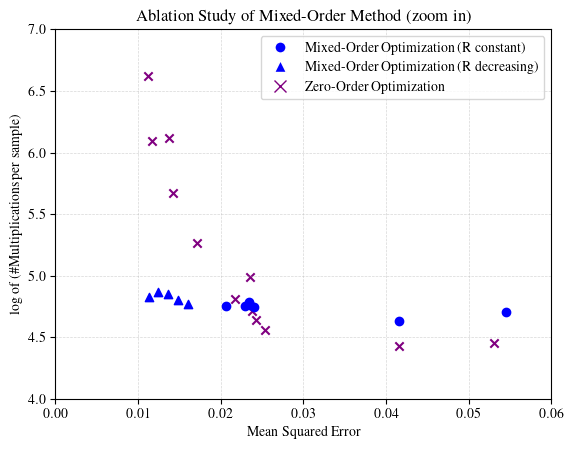

In [28]:
markers = ['o', '*', 'x']


for i in range(len(name_list)):
    marker_MT = 'o' if R_is_const_list[i] else '^'
    plt.scatter(MT_accuracies[i], np.log10(MT_complexities[i]),  marker=marker_MT, color='blue')
    plt.scatter(FOM_accuracies[i], np.log10(FOM_complexities[i]),  marker=markers[1], color='orange')
    plt.scatter(ZOM_accuracies[i], np.log10(ZOM_complexities[i]),  marker=markers[2],  color='purple')


plt.title('Ablation Study of Mixed-Order Method')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Mixed-Order Optimization (R constant)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Mixed-Order Optimization (R decreasing)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='*', color='w', label='First-Order Optimization', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='x', color='w', label='Zero-Order Optimization', markeredgecolor='purple',markersize=8, linestyle='None'),
]
plt.legend(handles=legend_elements)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.savefig('ablation_study.pdf', format='pdf', bbox_inches='tight')
plt.show()



# zoom in
for i in range(len(name_list)): 
    marker_MT = 'o' if R_is_const_list[i] else '^'
    plt.scatter(MT_accuracies[i], np.log10(MT_complexities[i]),  marker=marker_MT, color='blue')
    # plt.scatter(FOM_accuracies[i], np.log10(FOM_complexities[i]),  marker=markers[1], color='orange')
    plt.scatter(ZOM_accuracies[i], np.log10(ZOM_complexities[i]),  marker=markers[2],  color='purple')
plt.title('Ablation Study of Mixed-Order Method (zoom in)')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Mixed-Order Optimization (R constant)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Mixed-Order Optimization (R decreasing)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='x', color='w', label='Zero-Order Optimization', markeredgecolor='purple',  markersize=8, linestyle=None),
]
plt.legend(handles=legend_elements)
plt.xlim(0, 0.06)
plt.ylim(4, 7)
# plt.axvline(x=0.02, color='black', linestyle='--', linewidth=1)  
# plt.axvline(x=0.026, color='black', linestyle='--', linewidth=1)  
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.savefig('ablation_study_zoomin.pdf', format='pdf', bbox_inches='tight')
plt.show()